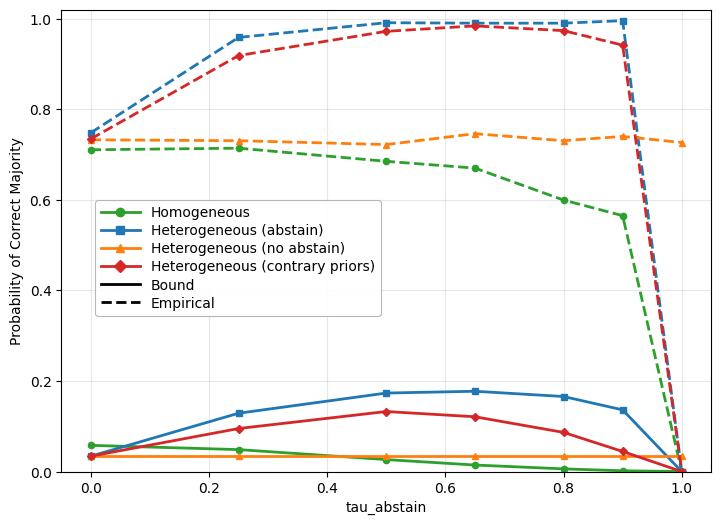

In [ ]:
# -*- coding: utf-8 -*-
"""
Azuma–Hoeffding lower bound for confidence-gated majority voting:
- Baselines: homogeneous & heterogeneous (aligned priors)
- New variant: heterogeneous with priors contrary to competence
- Simulates empirical success for comparison
- Plots vs chosen parameter (T or N or p_true or tau_abstain)

Dependencies: numpy, matplotlib, scipy
"""

import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   # <-- NEW: for custom legend handles
from scipy.special import betainc

# ------------------ EXPERIMENT CONFIG ------------------ #
param_to_vary = 'tau_abstain'

if param_to_vary == 'N':
    param_range = list(range(20, 106, 10))
elif param_to_vary == 'T':
    param_range = list(range(5, 26, 5))
elif param_to_vary == 'p_true':
    param_range = [0.52, 0.55, 0.58, 0.60, 0.65, 0.70]
elif param_to_vary == 'tau_abstain':
    param_range = [0.0, 0.25, 0.5, 0.65, 0.8, 0.9, 1]
else:
    raise ValueError("param_to_vary must be one of {'N','T','p_true','tau_abstain'}")

# Fixed parameters (used unless being varied)
FIXED = {
    'T': 20,
    'N': 50,
    'alpha_0': 1.0,
    'beta_0': 1.0,
    'p_critical': 0.5,
    'tau_abstain': 0.5,
    'p_true': 0.55
}

# Heterogeneous split
p_low, p_high = 0.35, 0.75

# Prior inversion strength κ (controls how confident the contrary prior is)
PRIOR_STRENGTH = 8.0
EPS = 1e-6

# Simulation runs per x-point
N_RUNS = 2000
RANDOM_SEED = 1337
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ------------------ UTIL FUNCTIONS ------------------ #
def beta_cdf(x, alpha, beta): return betainc(alpha, beta, x)

def prob_confidence_exceeds_threshold(alpha_0, beta_0, p_true, p_critical, tau_abstain,
                                      num_learning_trials, force_no_abstention=False):
    total_probability = 0.0
    n = num_learning_trials
    for k in range(n + 1):
        alpha_post = alpha_0 + k
        beta_post = beta_0 + (n - k)
        confidence = 1.0 - beta_cdf(p_critical, alpha_post, beta_post)
        publish = True if force_no_abstention else (confidence > tau_abstain)
        indicator = 1 if publish else 0
        binom_prob = math.comb(n, k) * (p_true ** k) * ((1 - p_true) ** (n - k))
        total_probability += indicator * binom_prob
    return total_probability

def expected_final_vote(N, T, alpha_0, beta_0, p_critical, tau_abstain, p_true,
                        force_no_abstention=False):
    q = prob_confidence_exceeds_threshold(alpha_0, beta_0, p_true, p_critical,
                                          tau_abstain, T - 1, force_no_abstention)
    EV = N * (2 * p_true - 1) * q
    return EV, q

def azuma_hoeffding_bound(N, T, expected_vote, p_true):
    variance_sum = N * ((T - 1) * (2 * p_true - 1) ** 2 + 4)
    if variance_sum == 0: return 1.0 if expected_vote > 0 else 0.0
    return 1 - math.exp(-(expected_vote ** 2) / (2 * variance_sum))

def azuma_hoeffding_bound_multi(N_list, T, expected_vote, reliabilities):
    variance_sum = 0.0
    for N_i, p_i in zip(N_list, reliabilities):
        variance_sum += N_i * ((T - 1) * (2 * p_i - 1) ** 2 + 4)
    if variance_sum == 0: return 1.0 if expected_vote > 0 else 0.0
    return 1 - math.exp(-(expected_vote ** 2) / (2 * variance_sum))

def build_contrary_priors(p_list, kappa=8.0, eps=1e-6):
    alpha0, beta0 = [], []
    for p in p_list:
        m = 1.0 - p
        alpha0.append(max(kappa * m, eps))
        beta0.append(max(kappa * (1.0 - m), eps))
    return alpha0, beta0

def expected_vote_with_per_agent_priors(T, p_list, alpha0_list, beta0_list,
                                        p_critical, tau_abstain, force_no_abstention=False):
    n = T - 1
    q_list = []
    for p, a0, b0 in zip(p_list, alpha0_list, beta0_list):
        q_i = prob_confidence_exceeds_threshold(a0, b0, p, p_critical, tau_abstain, n,
                                                force_no_abstention)
        q_list.append(q_i)
    EV = sum((2 * p - 1) * q for p, q in zip(p_list, q_list))
    return EV, q_list

def bound_with_per_agent_ps(T, EV, p_list):
    denom = sum(((T - 1) * (2 * p - 1) ** 2 + 4) for p in p_list)
    if denom == 0: return 1.0 if EV > 0 else 0.0
    return 1 - math.exp(-(EV ** 2) / (2.0 * denom))

# ------------------ SIMULATION ------------------ #
def simulate_trial(N, T, alpha_0, beta_0, p_critical, tau_abstain, p_vals,
                   force_no_abstention=False, n_runs=2000, alpha0_list=None, beta0_list=None):
    wins = 0
    p_list = list(p_vals) if isinstance(p_vals, (list, tuple, np.ndarray)) else [p_vals] * N
    if alpha0_list is not None and beta0_list is not None:
        start_priors = list(zip(alpha0_list, beta0_list))
    else:
        start_priors = [(alpha_0, beta_0)] * N

    for _ in range(n_runs):
        counts = [tuple(start_priors[i]) for i in range(N)]
        for _t in range(T - 1):
            for i, p in enumerate(p_list):
                success = 1 if random.random() < p else 0
                a, b = counts[i]
                counts[i] = (a + 1, b) if success == 1 else (a, b + 1)
        net = 0
        for i, p in enumerate(p_list):
            a, b = counts[i]
            conf = 1.0 - beta_cdf(p_critical, a, b)
            publish = True if force_no_abstention else (conf > tau_abstain)
            if publish:
                xT = 1 if random.random() < p else -1
                net += xT
        wins += (net > 0)
    return wins / n_runs

# ------------------ MAIN LOOP ------------------ #
x_vals = []
bounds_homogeneous, bounds_heterogeneous, bounds_hetero_no_abstain = [], [], []
emp_homogeneous, emp_heterogeneous, emp_hetero_no_abstain = [], [], []
bounds_contrary, emp_contrary = [], []

for val in param_range:
    P = dict(FIXED); P[param_to_vary] = val
    T = P['T']; N = P['N']; alpha_0 = P['alpha_0']; beta_0 = P['beta_0']
    p_critical = P['p_critical']; tau_abstain = P['tau_abstain']; p_true = P['p_true']

    # Homogeneous (aligned priors)
    EV_homo, q_homo = expected_final_vote(N, T, alpha_0, beta_0, p_critical, tau_abstain, p_true)
    bound_homo = azuma_hoeffding_bound(N, T, EV_homo, p_true)
    emp_homo_val = simulate_trial(N, T, alpha_0, beta_0, p_critical, tau_abstain, p_true, False, N_RUNS)

    # Heterogeneous (aligned priors, abstain)
    N1, N2 = N // 2, N - N // 2
    p_vals_het = [p_low] * N1 + [p_high] * N2
    EV_low, _ = expected_final_vote(N1, T, alpha_0, beta_0, p_critical, tau_abstain, p_low)
    EV_high, _ = expected_final_vote(N2, T, alpha_0, beta_0, p_critical, tau_abstain, p_high)
    EV_het = EV_low + EV_high
    bound_het = azuma_hoeffding_bound_multi([N1, N2], T, EV_het, [p_low, p_high])
    emp_het_val = simulate_trial(N, T, alpha_0, beta_0, p_critical, tau_abstain, p_vals_het, False, N_RUNS)

    # Heterogeneous (aligned, no abstain)
    EV_low_na, _ = expected_final_vote(N1, T, alpha_0, beta_0, p_critical, tau_abstain, p_low, True)
    EV_high_na, _ = expected_final_vote(N2, T, alpha_0, beta_0, p_critical, tau_abstain, p_high, True)
    EV_het_na = EV_low_na + EV_high_na
    bound_het_na = azuma_hoeffding_bound_multi([N1, N2], T, EV_het_na, [p_low, p_high])
    emp_het_na_val = simulate_trial(N, T, alpha_0, beta_0, p_critical, tau_abstain, p_vals_het, True, N_RUNS)

    # Heterogeneous (contrary priors, abstain)
    alpha_contrary, beta_contrary = build_contrary_priors(p_vals_het, kappa=PRIOR_STRENGTH, eps=EPS)
    EV_contrary, _ = expected_vote_with_per_agent_priors(
        T, p_vals_het, alpha_contrary, beta_contrary, p_critical, tau_abstain, False
    )
    bound_ctr = bound_with_per_agent_ps(T, EV_contrary, p_vals_het)
    emp_ctr_val = simulate_trial(
        N, T, alpha_0, beta_0, p_critical, tau_abstain, p_vals_het,
        False, N_RUNS, alpha0_list=alpha_contrary, beta0_list=beta_contrary
    )

    x_vals.append(val)
    bounds_homogeneous.append(bound_homo); emp_homogeneous.append(emp_homo_val)
    bounds_heterogeneous.append(bound_het); emp_heterogeneous.append(emp_het_val)
    bounds_hetero_no_abstain.append(bound_het_na); emp_hetero_no_abstain.append(emp_het_na_val)
    bounds_contrary.append(bound_ctr); emp_contrary.append(emp_ctr_val)

# ------------------ PLOTTING — single combined legend (mid-left), no title ------------------ #
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 6))

# Consistent colors
col_hom       = 'tab:green'
col_het_abst  = 'tab:blue'
col_het_no    = 'tab:orange'
col_contrary  = 'tab:red'

lw = 2.0
ms = 4.5

# Curves (solid = bound; dashed = empirical)
ax.plot(x_vals, bounds_homogeneous,        color=col_hom,      linestyle='-',  linewidth=lw, marker='o', markersize=ms)
ax.plot(x_vals, emp_homogeneous,           color=col_hom,      linestyle='--', linewidth=lw, marker='o', markersize=ms)

ax.plot(x_vals, bounds_heterogeneous,      color=col_het_abst, linestyle='-',  linewidth=lw, marker='s', markersize=ms)
ax.plot(x_vals, emp_heterogeneous,         color=col_het_abst, linestyle='--', linewidth=lw, marker='s', markersize=ms)

ax.plot(x_vals, bounds_hetero_no_abstain,  color=col_het_no,   linestyle='-',  linewidth=lw, marker='^', markersize=ms)
ax.plot(x_vals, emp_hetero_no_abstain,     color=col_het_no,   linestyle='--', linewidth=lw, marker='^', markersize=ms)

ax.plot(x_vals, bounds_contrary,           color=col_contrary, linestyle='-',  linewidth=lw, marker='D', markersize=ms)
ax.plot(x_vals, emp_contrary,              color=col_contrary, linestyle='--', linewidth=lw, marker='D', markersize=ms)

# Labels (no title)
ax.set_xlabel(param_to_vary)
ax.set_ylabel("Probability of Correct Majority")
ax.set_ylim(0.0, 1.02)
ax.grid(True, alpha=0.3)

# Leave room on the left for the legend box
fig.subplots_adjust(left=0.25)

from matplotlib.lines import Line2D

# --- One legend box that shows both colors (settings) and line styles ---
handles = [
    # Settings (color)
    Line2D([0],[0], color=col_hom,      lw=lw, marker='o', linestyle='-',  label='Homogeneous'),
    Line2D([0],[0], color=col_het_abst, lw=lw, marker='s', linestyle='-',  label='Heterogeneous (abstain)'),
    Line2D([0],[0], color=col_het_no,   lw=lw, marker='^', linestyle='-',  label='Heterogeneous (no abstain)'),
    Line2D([0],[0], color=col_contrary, lw=lw, marker='D', linestyle='-',  label='Heterogeneous (contrary priors)'),
    # Line styles (black)
    Line2D([0],[0], color='black',      lw=lw, linestyle='-',  label='Bound'),
    Line2D([0],[0], color='black',      lw=lw, linestyle='--', label='Empirical'),
]

legend = ax.legend(
    handles=handles,
    loc='upper right',                 # place legend corner that will sit on the anchor
    bbox_to_anchor=(0.5, 0.6),       # <-- inside the axes (tweak x∈[0,1], y∈[0,1])
    bbox_transform=ax.transAxes,       # interpret anchor in axes fraction coords
    ncol=1,
    frameon=True, fancybox=True, framealpha=0.95, edgecolor='0.7',
    handlelength=2.8, handletextpad=0.8, markerscale=1.0,
    borderaxespad=0.4, labelspacing=0.3
)
legend.get_frame().set_linewidth(0.8)